# Import Libraries

In [25]:
# %pip install -r requirements.txt
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import pickle
from cv2 import cv2
from skimage import feature
from sklearn import neighbors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Retrieve Dataset

In [26]:
from preprocess import retrieve_dataset, preprocess, to_np, count_class

(train_ds_raw, test_ds_raw), metadata = retrieve_dataset(should_shuffle_files=True)

train_ds = preprocess(train_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 300,
  'is_grayscale': False, 
  'is_downsample64': False,
  'is_downsample128': False, 
  'is_normalize': False,
})

test_ds = preprocess(test_ds_raw, {
  'is_undersample_negative': True,
  'reduce_dataset_to': 75,
  'is_grayscale': False, 
  'is_downsample64': False, 
  'is_downsample128': False, 
  'is_normalize': False,
})

initial_state = dict((i, 0) for i in range(9))
counts = train_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for train dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

initial_state = dict((i, 0) for i in range(9))
counts = test_ds.reduce(initial_state=initial_state,
                         reduce_func=count_class)

print("Class breakdown for test dataset:")
print([(k, v.numpy()) for k, v in counts.items()])

Class breakdown for train dataset:
[(0, 45), (1, 37), (2, 35), (3, 27), (4, 28), (5, 35), (6, 27), (7, 26), (8, 0)]
Class breakdown for test dataset:
[(0, 10), (1, 9), (2, 8), (3, 5), (4, 9), (5, 11), (6, 5), (7, 10), (8, 0)]


# Extract X_train, Y_train, X_test, Y_test

In [27]:
train_ds_numpy = to_np(train_ds)
test_ds_numpy = to_np(test_ds)

In [28]:
X_train = [example for example, label in train_ds_numpy]
y_train = [label for example, label in train_ds_numpy]

X_test = [example for example, label in test_ds_numpy]
y_test = [label for example, label in test_ds_numpy]

# Visualize Preprocessed Dataset

Length of X_train: 300
Length of X_test: 75


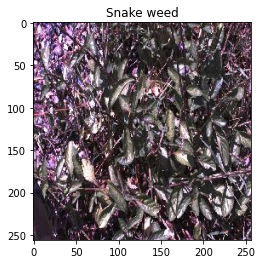

In [29]:
from visualize import visualize, compare

visualize(X_train[0], y_train[0], metadata)
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

# Perform Transfer Learning

In [30]:
# Reference: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

from transfer_learning import init_conv_base, extract_features
conv_base = init_conv_base(X_train[0])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [31]:
train_features, train_labels = extract_features(conv_base, X_train, y_train)  # Agree with our small dataset size
test_features, test_labels = extract_features(conv_base, X_test, y_test)

## Flatten To Feed into Different Algorithms

In [32]:
X_train_flatten = list(map(lambda x: x.flatten(), train_features))
y_train = train_labels
X_test_flatten = list(map(lambda x: x.flatten(), test_features))
y_test = test_labels

print(train_labels.shape)
print("feature size now:", X_train[0].shape) # orginal feature is of dimension 196608

(300,)
feature size now: (256, 256, 3)


In [33]:
X_full = list(X_train_flatten) + list(X_test_flatten)
y_full = list(y_train) + list(y_test)

print(len(X_full))
print(len(y_full))

375
375


# Test SVM Model with K-Fold Validation

In [34]:
from run_algo_with_kfold import kfold_cross_validation

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
k = 5
clfs_and_accuracies = []
for kernel in kernels:
  clf_and_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': kernel})
  clfs_and_accuracies.append(clf_and_accuracy)

Running 5-fold cross validation for svm with {'kernel': 'linear'}
Loaded kfold model from file: models/svm_kernellinear_0.pickle
Split accuracy: 0.5333333333333333
Loaded kfold model from file: models/svm_kernellinear_1.pickle
Split accuracy: 0.48333333333333334
Loaded kfold model from file: models/svm_kernellinear_2.pickle
Split accuracy: 0.5333333333333333
Loaded kfold model from file: models/svm_kernellinear_3.pickle
Split accuracy: 0.5166666666666667
Loaded kfold model from file: models/svm_kernellinear_4.pickle
Split accuracy: 0.5333333333333333
Completed 5-fold cross validation for svm with {'kernel': 'linear'}
Obtained average accuracy of: 0.5199999999999999

Loaded model from file: models/svm_kernellinear.pickle
Running 5-fold cross validation for svm with {'kernel': 'rbf'}
Loaded kfold model from file: models/svm_kernelrbf_0.pickle
Split accuracy: 0.15
Loaded kfold model from file: models/svm_kernelrbf_1.pickle
Split accuracy: 0.16666666666666666
Loaded kfold model from file: 

In [35]:
print(clfs_and_accuracies)

[(SVC(C=0.01, decision_function_shape='ovo', kernel='linear', probability=True), 0.5333333333333333), (SVC(C=0.01, decision_function_shape='ovo', probability=True), 0.16666666666666666), (SVC(C=0.01, decision_function_shape='ovo', kernel='poly', probability=True), 0.16666666666666666), (SVC(C=0.01, decision_function_shape='ovo', kernel='sigmoid', probability=True), 0.16666666666666666)]


In [36]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import get_precision_scores, get_roc_auc_curve

In [37]:
for clf, accuracy in clfs_and_accuracies:
  print(get_precision_scores(clf, X_full, y_full))

{'accuracy': 0.5173333333333333, 'macro_avg': 0.5015006425419006, 'f1_score_macro': 0.49409026282848334, 'micro_avg': 0.5173333333333333, 'f1_score_micro': 0.5173333333333333, 'roc_auc_score': 0.8871329837509122}
{'accuracy': 0.11466666666666667, 'macro_avg': 0.11466666666666667, 'f1_score_macro': 0.20574162679425836, 'micro_avg': 0.11466666666666667, 'f1_score_micro': 0.20574162679425836, 'roc_auc_score': 0.779016347935669}
{'accuracy': 0.11466666666666667, 'macro_avg': 0.11466666666666667, 'f1_score_macro': 0.20574162679425836, 'micro_avg': 0.11466666666666667, 'f1_score_micro': 0.20574162679425836, 'roc_auc_score': 0.782723343910783}
{'accuracy': 0.11466666666666667, 'macro_avg': 0.11466666666666667, 'f1_score_macro': 0.20574162679425836, 'micro_avg': 0.11466666666666667, 'f1_score_micro': 0.20574162679425836, 'roc_auc_score': 0.7763381643229109}


In [38]:
fprs = []
tprs = []
roc_aucs = []
for clf, accuracy in clfs_and_accuracies:
  (fpr, tpr, roc_auc) = get_roc_auc_curve(clf, X_train_flatten, y_train, X_test_flatten, y_test, {'is_svm': True})
  fprs.append(fpr)
  tprs.append(tpr)
  roc_aucs.append(roc_auc)

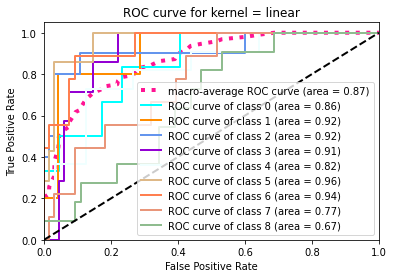

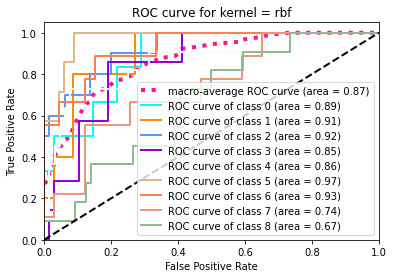

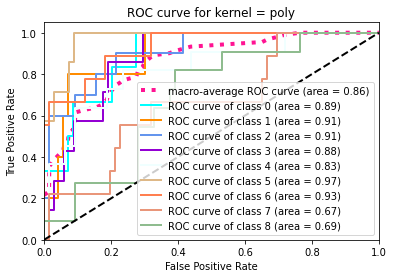

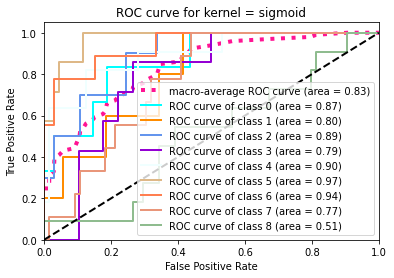

In [39]:
import importlib
import run_algo_with_kfold
importlib.reload(run_algo_with_kfold)
from run_algo_with_kfold import visualize_roc_auc_curve
for kernel, fpr, tpr, roc_auc in zip(kernels, fprs, tprs, roc_aucs):
  title = f'ROC curve for kernel = {str(kernel)}'
  visualize_roc_auc_curve(title, fpr, tpr, roc_auc, len(np.unique(y_test)))

In [ ]:
from grad_cam import show_heat_map
show_heat_map(clfs_and_accuracies, X_test, test_features, 152)

## Old Results

In [17]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.125, 0.5, 2, 8, 32]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C, 'gamma': 'scale'})
  final_accuracies.append(final_accuracy)
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C, 'gamma': 'auto'})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'scale'}
Obtained split accuracy of: 0.7685393258426966
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7683658170914542
Obtained split accuracy of: 0.7616191904047976
Obtained split accuracy of: 0.7548725637181409
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'scale'}
Obtained average accuracy of: 0.7594434243552382
Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'auto'}
Obtained split accuracy of: 0.7685393258426966
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7683658170914542
Obtained split accuracy of: 0.7616191904047976
Obtained split accuracy of: 0.7548725637181409
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.125, 'gamma': 'auto'}
Obtained average accuracy of: 0.7594434243552382
Running 5-fold cross validation for svm with {

In [ ]:
print(final_accuracies)

In [9]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.023, 0.024, 0.025, 0.026, 0.027]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.023}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.023}
Obtained average accuracy of: 0.7592933870143581

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.024}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.024}
Obtained average accuracy of: 0.7592933870143581

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.025}
Obtained split accuracy of: 0.769288

KeyboardInterrupt: 

In [ ]:
print(final_accuracies)

[]


In [10]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.01, 0.04, 0.16, 0.64]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.01}
Obtained split accuracy of: 0.7685393258426966
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.760119940029985
Obtained split accuracy of: 0.7473763118440779
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.01}
Obtained average accuracy of: 0.7592934993177568

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.04}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7766116941529235
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.04}
Obtained average accuracy of: 0.7592933870143581

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.16}
Obtained split accuracy of: 0.769288389513

In [11]:
print(final_accuracies)

[0.7592934993177568, 0.7592933870143581, 0.7592933870143581, 0.7592933870143581]


In [13]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.005, 0.015]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)
print(final_accuracies)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.005}
Obtained split accuracy of: 0.7752808988764045
Obtained split accuracy of: 0.748314606741573
Obtained split accuracy of: 0.7811094452773614
Obtained split accuracy of: 0.7698650674662668
Obtained split accuracy of: 0.7443778110944528
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.005}
Obtained average accuracy of: 0.7637895658912118

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.015}
Obtained split accuracy of: 0.7692883895131086
Obtained split accuracy of: 0.7438202247191011
Obtained split accuracy of: 0.7773613193403298
Obtained split accuracy of: 0.7608695652173914
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.015}
Obtained average accuracy of: 0.7594433120518392

[0.7637895658912118, 0.7594433120518392]


In [14]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.00125, 0.0025, 0.013, 0.017, 0.02]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)
print(final_accuracies)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.00125}
Obtained split accuracy of: 0.7737827715355805
Obtained split accuracy of: 0.7415730337078652
Obtained split accuracy of: 0.7593703148425787
Obtained split accuracy of: 0.7616191904047976
Obtained split accuracy of: 0.7473763118440779
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.00125}
Obtained average accuracy of: 0.75674432446698

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.0025}
Obtained split accuracy of: 0.7797752808988764
Obtained split accuracy of: 0.749812734082397
Obtained split accuracy of: 0.7706146926536732
Obtained split accuracy of: 0.7668665667166417
Obtained split accuracy of: 0.7421289355322339
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.0025}
Obtained average accuracy of: 0.7618396419767646

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.013}
Obtained split accuracy of: 0.767

In [15]:
from run_algo_with_kfold import kfold_cross_validation

Cs = [0.003, 0.004, 0.006, 0.007, 0.008]
k = 5
final_accuracies = []
for C in Cs:
  final_accuracy = kfold_cross_validation(k, X_train_flatten, y_train, 'svm', {'kernel': 'linear', 'C': C})
  final_accuracies.append(final_accuracy)
print(final_accuracies)

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.003}
Obtained split accuracy of: 0.7782771535580524
Obtained split accuracy of: 0.752059925093633
Obtained split accuracy of: 0.7773613193403298
Obtained split accuracy of: 0.7646176911544228
Obtained split accuracy of: 0.7458770614692654
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.003}
Obtained average accuracy of: 0.7636386301231407

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.004}
Obtained split accuracy of: 0.7760299625468164
Obtained split accuracy of: 0.7445692883895131
Obtained split accuracy of: 0.7743628185907047
Obtained split accuracy of: 0.7683658170914542
Obtained split accuracy of: 0.7428785607196402
Completed 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.004}
Obtained average accuracy of: 0.7612412894676257

Running 5-fold cross validation for svm with {'kernel': 'linear', 'C': 0.006}
Obtained split accuracy of: 0.7752808